# Parameters

In [1]:
#中文采用了清华NLP组提供的THUCNews新闻文本分类数据集的子集
destination_folder = './model_xlnet_cn'
data_address = '../Data_Cn/'
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext.legacy import data
from torchtext.legacy import datasets
import torchtext
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from tqdm import tqdm, trange
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from transformers import AdamW
use_cuda=torch.cuda.is_available()
device=torch.device("cuda" if use_cuda else "cpu")
from keras.preprocessing.sequence import pad_sequences
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
import pandas as pd
train_data = pd.read_csv(data_address+'cnews.train.txt',sep='\t',names=['label','content'])
test_data = pd.read_csv(data_address+'cnews.test.txt',sep='\t',names=['label','content'])
dev_data = pd.read_csv(data_address+'cnews.val.txt',sep='\t',names=['label','content'])



In [4]:
df_all = pd.concat([train_data,test_data,dev_data])
df_all = df_all.reset_index()
df_all = df_all.drop(['index'], axis=1)

In [5]:
status_dict = df_all['label'].unique().tolist()
df_all['d_label'] = df_all['label'].apply(lambda x : status_dict.index(x))

In [6]:
df_all.head()

,label,content,d_label
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...,0
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...,0
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...,0
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...,0
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...,0


In [7]:
df_all['content'][2000]

'160万小将让人又爱又恨 如此不稳流言纷飞该怪谁新浪体育讯华盛顿奇才86-95不敌印第安纳步行者，贾维尔-麦基拿下7分3个篮板。本场比赛来到步行者的主场，但是麦基没能再次发挥出应有的作用。本场比赛他自己没有盖帽不说，还让希伯特拿下17分8个篮板。希伯特在场上打了31分钟，反倒是麦基自己的上场时间缩水到18分钟。奇才内线基本上是不设防的，他们让对方五人得分上双，尽管今天步行者的三分球命中率一般，19投仅仅5中，但是除了三分球之外他们59投33中。作为奇才的防守中坚，麦基要负起主要责任。在上一场比赛结束之后，代理主教练兰迪-惠特曼对麦基是赞不绝口，说他们之前研究过比赛录像带，而麦基在比赛中完全执行了教练的意图。但是本场比赛结束之后，麦基又从两天前人们口中的防守天才变成了蠢货。比赛中他并不是没有亮点，开场麦基就让奇才首先得分，在安德雷-布莱切投篮不中的情况下，他还扛起进攻大旗，在希伯特面前玩起了篮下脚步，轻松晃过命中。但是他出糗的场景更多。比赛开始之后他尝试扣篮被希伯特犯规，但是回到防守端，绕前防守希伯特被后者双手暴扣示威。此后他在篮下抢到篮板，二次进攻的时候又遭到迈克-邓利维的封盖。第三节开始之后，麦基再次得到二次进攻机会，但是他的补扣却砸框弹飞。此后他终于觅得表演机会，步行者的外线传球被麦基一把抢断，他带球直冲本方禁区，气势无人可挡，最后以一记单臂暴扣结束了一条龙的表演。可惜他的彪悍表演刚刚开始就被掐灭了，回到防守端希伯特马上就还以颜色，他强打麦基造成后者犯规，这是麦基本场比赛的第四次犯规，他不得不下场休息。菲利普-桑德斯刚一回来，麦基就犯了老毛病，这让桑帅有点气不打一处来。本以为麦基可以凭借对阵希伯特的表现成为奇才防守的依靠，哪知道两天内第二次会面他就露馅了。不知道桑帅会不会在心里大骂烂泥扶不上墙。(春水方生)'

In [8]:
sentences = df_all.content.values

In [9]:
#把句号替换掉？好似不用
#sentences = [sentence.replace('。','[SEP] ') + " [CLS]" for sentence in sentences]
labels = df_all.d_label.values

# 分词

In [10]:
from transformers import BertTokenizer
tokenizer = XLNetTokenizer.from_pretrained('../utils/chinese-xlnet-base', do_lower_case=False)

In [11]:
# xlnet的模型输入需要两个mask，不能依赖torchtext了
#格式：Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
#本中文数据集有多句话组成，由于是新闻，由句号分割

In [12]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁马', '晓', '旭', '意外', '受伤', '让', '国', '奥', '警', '惕', '▁', '无', '奈', '大雨', '格', '外', '青', '睐', '殷', '家', '军', '记者', '傅', '亚', '雨', '沈阳', '报道', '▁', '来到', '沈阳', ',', '国', '奥', '队', '依然', '没有', '摆脱', '雨水', '的', '困', '扰', '。', '7', '月', '31', '日下午', '6', '点', ',', '国', '奥', '队的', '日常', '训练', '再度', '受到', '大雨', '的', '干扰', ',', '无', '奈', '之下', '队员', '们', '只', '慢', '跑', '了', '25', '分钟', '就', '草', '草', '收', '场', '。', '31', '日上午', '10', '点', ',', '国', '奥', '队', '在', '奥', '体', '中心', '外', '场', '训练', '的时候', ',', '天', '就是', '阴', '沉', '沉', '的', ',', '气象', '预', '报', '显示', '当天', '下午', '沈阳', '就有', '大雨', ',', '但', '幸', '好', '队伍', '上午', '的', '训练', '并没有', '受到', '任何', '干扰', '。', '下午', '6', '点', ',', '当', '球队', '抵达', '训练', '场', '时', ',', '大雨', '已经', '下了', '几个', '小时', ',', '而且', '丝', '毫', '没有', '停', '下来', '的意思', '。', '抱', '着', '试', '一', '试', '的', '态度', ',', '球队', '开始了', '当天', '下午', '的', '例', '行', '训练', ',', '25', '分钟', '过去', '了', ',', '天气', '没有任何', '转', '好的', '迹', '象', ',', '为了',

In [13]:
#设备限制，虽然xlnet支持长段落，但这里还是128稳妥
MAX_LEN = 128

In [14]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [15]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [16]:
# 储存mask的值
attention_masks = []

# padding不需要mask
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [17]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=SEED, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=SEED, test_size=0.1)

In [18]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [19]:
batch_size = 16

# iterator 

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# MODEL

In [20]:
model = XLNetForSequenceClassification.from_pretrained("../utils/chinese-xlnet-base", num_labels=10)
model.cuda()

Some weights of the model checkpoint at ../utils/chinese-xlnet-base were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at ../utils/chinese-xlnet-base and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to us

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [21]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [22]:
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [23]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:

train_loss_set = []

epochs = 4

for _ in trange(epochs, desc="Epoch"):
  
    model.train()
  
  #统计训练指标
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(train_dataloader):
        # 传给设备
        batch = tuple(t.to(device) for t in batch)
        # 解包变量
        b_input_ids, b_input_mask, b_labels = batch
        # 清零opt梯度信息
        optimizer.zero_grad()
        # 前向传播
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # 反向传播
        loss.backward()
        # 更新优化参数
        optimizer.step()


        # 更新训练指标
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # 验证部分
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
   
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad(): #不更新梯度
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.14419138695837638


Epoch:  25%|██▌       | 1/4 [14:53<44:39, 893.11s/it]

Validation Accuracy: 0.9738943488943489
Train loss: 0.05280072755698995


Epoch:  50%|█████     | 2/4 [29:45<29:45, 892.60s/it]

Validation Accuracy: 0.9768120393120393
Train loss: 0.030269932866221667


Epoch:  75%|███████▌  | 3/4 [44:38<14:52, 892.76s/it]

Validation Accuracy: 0.9768120393120393
Train loss: 0.02112672677192899


Epoch: 100%|██████████| 4/4 [59:32<00:00, 893.10s/it]

Validation Accuracy: 0.9761977886977887


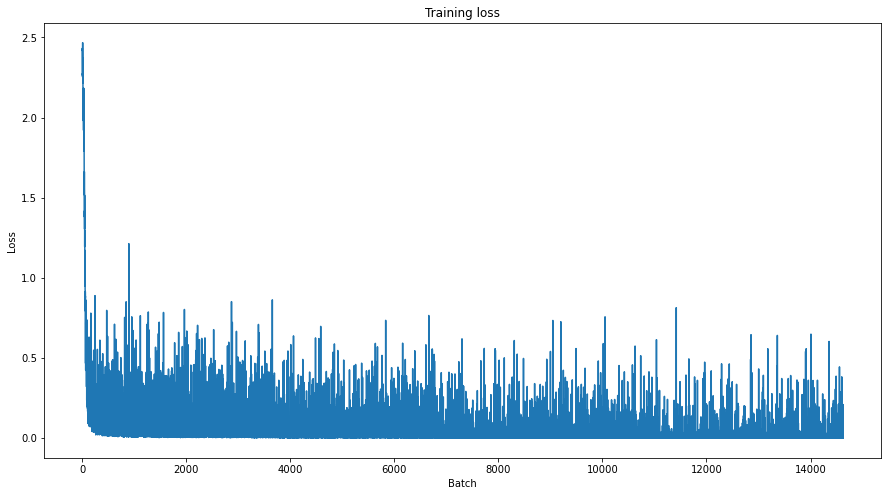

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()